# Importing the libraries

In [1]:
!pip install torch_geometric
!pip install apyori

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data Preprocessing

In [3]:
dataset = pd.read_csv('session_data.csv')

In [4]:
# removing separators and putting items into a list
def process_transactions(transaction):
    items = transaction.replace('&', ',').split(',')
    # Remove white spaces and add to the processed list
    items = [item.strip() for item in items]
    return items

In [5]:
dataset['product_name'] = dataset['product_name'].apply(process_transactions)

In [6]:
# combining all items of same session into a list (union-ing all lists of same session ids)
def combine_product_names(product_lists):
    combined_list = []
    for product_list in product_lists:
        combined_list.extend(product_list)
    return combined_list

In [7]:
df_cleaned = dataset.groupby('session_id')['product_name'].apply(combine_product_names).reset_index()

In [8]:
transactions = df_cleaned.values[:, 1]
transactions2 = transactions # For Apriori
transactions

array([list(['fresh cow milk', 'curd']),
       list(['gourds', 'rain accessories']),
       list(['fresh beans', 'gourds']), ...,
       list(['fresh cow milk', 'curd']),
       list(['tender coconut', 'baby fruits']),
       list(['cucumber', 'beetroot'])], dtype=object)

In [9]:
# Create a mapping from product names to unique IDs
product_to_id = {product: idx for idx, product in enumerate(set(item for transaction in transactions for item in transaction))}
id_to_product = {idx: product for product, idx in product_to_id.items()}

In [10]:
product_to_id

{'blended oil': 0,
 'brown eggs': 1,
 'kitchen towel': 2,
 'compact': 3,
 'blender': 4,
 'flavoured crackers': 5,
 'cross bags': 6,
 'palm oil': 7,
 'shringar': 8,
 'laptop bags': 9,
 'digestive salts': 10,
 'hair shampoo': 11,
 'nail accessories': 12,
 'chocolate cup': 13,
 'deodorant body spray': 14,
 'diffusers': 15,
 'body soaps': 16,
 'veg momos': 17,
 'curry leaves': 18,
 'pastries': 19,
 'garlic': 20,
 'flakes': 21,
 'mustard seeds': 22,
 'foot mask': 23,
 'dried fruit': 24,
 'vermicelli': 25,
 'primer': 26,
 'kajal': 27,
 'wafer cubes': 28,
 'makeup accessories': 29,
 'earbuds': 30,
 'international travel adapter': 31,
 'paste': 32,
 'recipe masala': 33,
 'banana': 34,
 'jamun': 35,
 'cooking butter': 36,
 'almond milk': 37,
 'a2 ghee': 38,
 'chips': 39,
 'pet powder': 40,
 'shaker': 41,
 'colours': 42,
 'detergent powder': 43,
 'sunglasses': 44,
 'crunchy': 45,
 'kitchen king masala': 46,
 'sambrani': 47,
 'cleaning': 48,
 'tamarind': 49,
 'body accessories': 50,
 'lipstick se

# EDA

In [11]:
# Calculate the number of unique products
unique_products = set(item for transaction in transactions for item in transaction)
num_unique_products = len(unique_products)
print(f'Number of unique products: {num_unique_products}')

Number of unique products: 430


In [12]:
# Calculate the number of transactions
num_transactions = len(transactions)
print(f'Number of transactions: {num_transactions}')

Number of transactions: 165335


In [13]:
# Distribution of the number of items per transaction
num_items_per_transaction = [len(transaction) for transaction in transactions]
print(f'Average number of items per transaction: {np.mean(num_items_per_transaction):.2f}')
print(f'Maximum number of items in a transaction: {np.max(num_items_per_transaction)}')
print(f'Minimum number of items in a transaction: {np.min(num_items_per_transaction)}')

Average number of items per transaction: 2.20
Maximum number of items in a transaction: 9
Minimum number of items in a transaction: 2


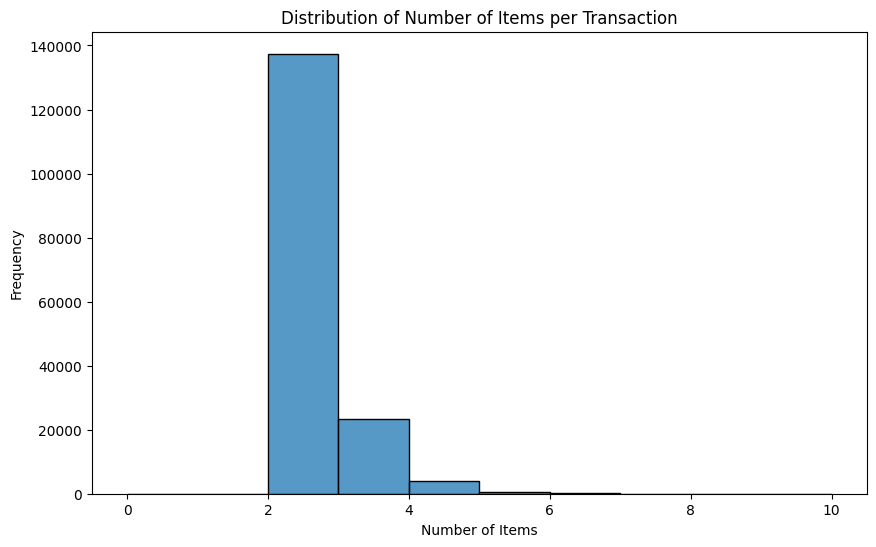

In [14]:
# Plot the distribution of the number of items per transaction
plt.figure(figsize=(10, 6))
sns.histplot(num_items_per_transaction, bins=range(0, max(num_items_per_transaction) + 2))
plt.title('Distribution of Number of Items per Transaction')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.show()

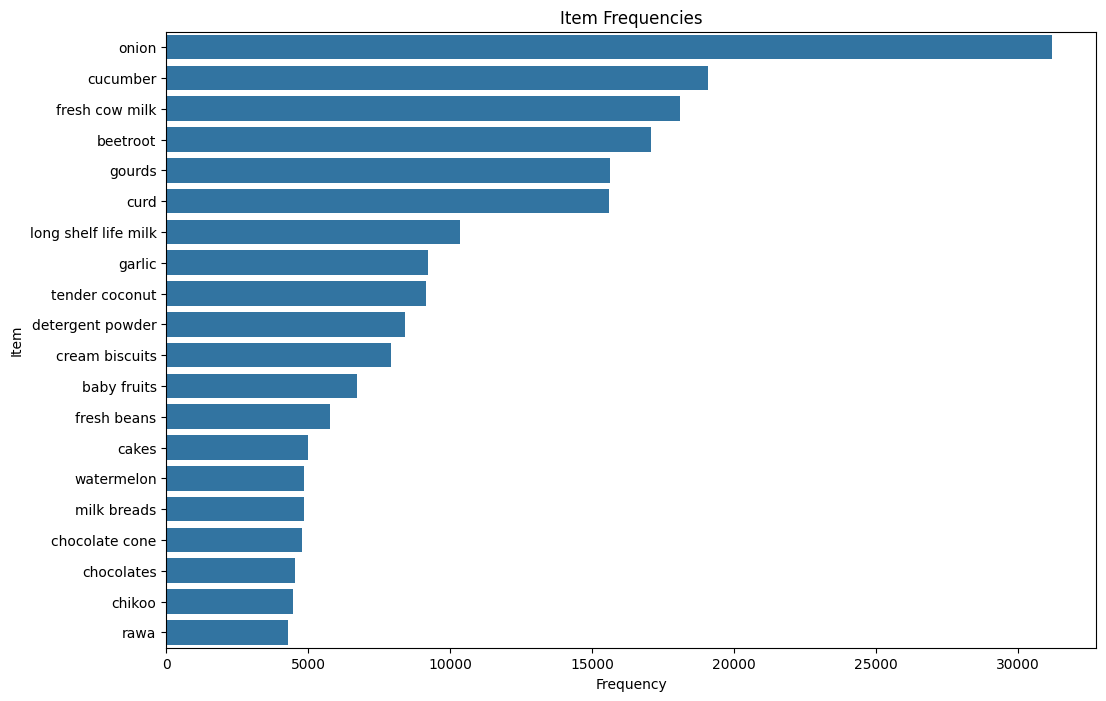

In [15]:
from collections import Counter
# Flatten the list of transactions to count item frequencies
all_items = [item for transaction in transactions for item in transaction]
item_frequencies = Counter(all_items)

# Convert to DataFrame for easier plotting
df_item_frequencies = pd.DataFrame(item_frequencies.items(), columns=['Item', 'Frequency'])

# Plot the item frequencies
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Item', data=(df_item_frequencies.sort_values(by='Frequency', ascending=False)).nlargest(20, 'Frequency'))
plt.title('Item Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Item')
plt.show()

# GNN Model Training

In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split

In [17]:
# Convert transactions to IDs
transactions = [[product_to_id[item] for item in transaction] for transaction in transactions]

# Create an edge list
edge_list = defaultdict(int)
for transaction in transactions:
    for i in range(len(transaction)):
        for j in range(i + 1, len(transaction)):
            edge_list[(transaction[i], transaction[j])] += 1
            edge_list[(transaction[j], transaction[i])] += 1

# Convert edge list to PyTorch Geometric format
edge_index = torch.tensor(list(edge_list.keys()), dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(list(edge_list.values()), dtype=torch.float)

# Node features (one-hot encoding)
num_items = len(product_to_id)
x = torch.eye(num_items)

# Labels (optional, for semi-supervised learning)
y = torch.arange(num_items)

# Create PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

In [18]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

In [19]:
def train(model, data, optimizer, criterion, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Split data into training and test sets
train_mask, test_mask = train_test_split(np.arange(num_items), test_size=0.2)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)
tot_mask = torch.tensor(np.arange(num_items), dtype=torch.long)

# Initialize model, optimizer, and loss function
model = GCN(num_features=num_items, hidden_dim=16, num_classes=num_items)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 600
for epoch in range(epochs):
    loss = train(model, data, optimizer, criterion, tot_mask)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')


Epoch 0, Loss: 6.0638
Epoch 10, Loss: 6.0056
Epoch 20, Loss: 5.8645
Epoch 30, Loss: 5.7553
Epoch 40, Loss: 5.6175
Epoch 50, Loss: 5.4405
Epoch 60, Loss: 5.2185
Epoch 70, Loss: 4.9593
Epoch 80, Loss: 4.6786
Epoch 90, Loss: 4.3908
Epoch 100, Loss: 4.1094
Epoch 110, Loss: 3.8470
Epoch 120, Loss: 3.6098
Epoch 130, Loss: 3.3970
Epoch 140, Loss: 3.2050
Epoch 150, Loss: 3.0296
Epoch 160, Loss: 2.8671
Epoch 170, Loss: 2.7148
Epoch 180, Loss: 2.5707
Epoch 190, Loss: 2.4332
Epoch 200, Loss: 2.3016
Epoch 210, Loss: 2.1752
Epoch 220, Loss: 2.0538
Epoch 230, Loss: 1.9372
Epoch 240, Loss: 1.8253
Epoch 250, Loss: 1.7182
Epoch 260, Loss: 1.6158
Epoch 270, Loss: 1.5181
Epoch 280, Loss: 1.4251
Epoch 290, Loss: 1.3367
Epoch 300, Loss: 1.2530
Epoch 310, Loss: 1.1739
Epoch 320, Loss: 1.0993
Epoch 330, Loss: 1.0291
Epoch 340, Loss: 0.9630
Epoch 350, Loss: 0.9011
Epoch 360, Loss: 0.8430
Epoch 370, Loss: 0.7886
Epoch 380, Loss: 0.7377
Epoch 390, Loss: 0.6902
Epoch 400, Loss: 0.6458
Epoch 410, Loss: 0.6044
Epo

In [20]:
# Function to take in input item and give top k values
def recommend(model, data, item_id, top_k=5, exclude_purchased=True):
    model.eval()
    with torch.no_grad():
        out = model(data)
        # Normalize embeddings
        norm_out = F.normalize(out, p=2, dim=1)
        item_embedding = norm_out[item_id]
        similarities = torch.matmul(norm_out, item_embedding)

        # Exclude already purchased items if needed
        if exclude_purchased:
            mask = torch.ones_like(similarities, dtype=torch.bool)
            mask[item_id] = False
            similarities = similarities * mask

        recommendations = similarities.topk(top_k + 1).indices
        return recommendations[recommendations != item_id][:top_k]

In [21]:
try:
  # Get recommendations for a given product name
  product_name = "curd"
  item_id = product_to_id[product_name]  # Convert product name to ID
  recommendations = recommend(model, data, item_id)
  # Convert recommended IDs back to product names
  recommended_products = [id_to_product[item] for item in recommendations.tolist()]
  print(f'Recommendations for {product_name}: {recommended_products}')

except:
  print(f'Product {product_name} not found in the dataset.')

Recommendations for curd: ['fresh cow milk', 'gourds', 'garlic', 'fruit juices', 'watermelon']


# Aprior (For evaluating GNN performance qualitatively)

## Training the Apriori model on the dataset

In [22]:
from apyori import apriori
rules = apriori(transactions = transactions2, min_support = 0.001, min_confidence = 0.01, min_lift = 3, min_length = 2, max_length = 2)

## Visualising the results

### Displaying the first results coming directly from the output of the apriori function

In [23]:
results = list(rules)

### Putting the results well organised into a Pandas DataFrame

In [24]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])

### Displaying the results non sorted

In [25]:
resultsinDataFrame

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
0,agarbatti,incense sticks,0.007518,1.000000,133.012872
1,agarbatti,matchbox,0.001651,0.219630,12.084031
2,amaranthus,gourd,0.001331,0.138889,11.447255
3,appalam,papads,0.002480,1.000000,403.256098
4,baby fruits,chikoo,0.007718,0.189881,7.012278
5,baby fruits,tender coconut,0.008226,0.202381,3.654905
6,banana,grapes,0.001234,0.302222,33.113261
7,bar chocolates,chocolates,0.001917,0.233088,8.507206
8,beetroot,cucumber,0.051985,0.503309,4.360662
9,beetroot,fresh beans,0.011649,0.112783,3.231160


### Displaying the results sorted by descending lifts

In [27]:
print(resultsinDataFrame.nlargest(n = 50, columns = 'Lift'))

          Left Hand Side      Right Hand Side   Support  Confidence  \
19                  chai                  tea  0.001040    1.000000   
48                  more  soapcase dispensers  0.001367    1.000000   
24                chowli               lobiya  0.001748    1.000000   
49     personal massager             vibrator  0.001827    1.000000   
47                   mop                pocha  0.001990    1.000000   
3                appalam               papads  0.002480    1.000000   
45                kismis              raisins  0.002788    1.000000   
44             khus-khus          poppy seeds  0.003411    1.000000   
38            fried gram        roasted chana  0.003629    1.000000   
30  crispy peanut butter              crunchy  0.004022    1.000000   
0              agarbatti       incense sticks  0.007518    1.000000   
42                 jamun          pomegranate  0.001034    0.424318   
14          buffalo ghee            desi ghee  0.008462    1.000000   
15    